# Constants

In [1]:
NUMBER_OF_PROCESSORS = 20
CLUSTERS_WIDTH = 1.5 # Default: 2.0
WATER_IDS = [['B', 1, ' OW ']]
FIRST_ATOMS_TO_IGNORE = 1

# Imports

In [2]:
from PELETools import ControlFileParser as cfp
from PELETools import SimulationParser as sp
from ReportMetrics import Metrics
from sklearn import cluster
from multiprocessing import Pool
import statistics
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

# Functions

In [3]:
def obtain_water_data_from(control_file_path):
    print('- Parsing control file...')
    builder = cfp.ControlFileBuilder(control_file_path)
    cf = builder.build()
    sim = cf.getSimulation()
    
    print('- Listing reports...')
    list_of_reports = []
    for report in sim.iterateOverReports:
        list_of_reports.append(report)
    
    print('- Retrieving data...')
    with Pool(NUMBER_OF_PROCESSORS) as pool:
        atom_data = pool.map(parallel_atom_getter, list_of_reports)
    
    fixed_atom_data = []
    
    print('- Linking report pointers...')
    for (path, name), atom_coords in atom_data:
        for report in list_of_reports:
            if ((report.path, report.name) == (path, name)):
                report_pointer_to_add = report
                break
        else:
            raise NameError("Report {}{} not found".format(path, name))
        fixed_atom_data.append((report_pointer_to_add, atom_coords))
    
    print('- Parsing data...')
    return split_atom_data(fixed_atom_data), list_of_reports

In [4]:
def parallel_atom_getter(report):
    atom_coords = {}
    for i, water_id in enumerate(WATER_IDS):
        atoms = report.trajectory.getAtoms(water_id)
        for j, atom in enumerate(atoms[FIRST_ATOMS_TO_IGNORE:]):
            atom_coords[(i, j + FIRST_ATOMS_TO_IGNORE)] = atom.coords
    
    atom_data = ((report.path, report.name), atom_coords)
    return atom_data

In [5]:
def split_atom_data(atom_data):
    atom_reports = []
    atom_ids = []
    atom_models = []
    atom_coords = []

    for data in atom_data:
        for (water_id, model), coords in data[1].items():
            atom_reports.append(data[0])
            atom_ids.append(water_id)
            atom_models.append(model)
            atom_coords.append(coords)

    return atom_reports, atom_ids, atom_models, atom_coords

In [6]:
def get_density(atom_ids, results):
    n_clusters = int(max(results) + 1)
    
    # Initialize density dictionary
    density = {}
    for iteration_id in range(0, n_clusters):
        density[iteration_id] = 0

    for water_id in range(0, len(WATER_IDS)):
        for i, atom_id in enumerate(atom_ids):
            if (atom_id == water_id):
                density[results[i]] += 1
                
    # Normalize
    norm_factor = 1 / (len(results) / len(WATER_IDS))

    for iteration_id in range(0, n_clusters):
        density[iteration_id] *= norm_factor
                
    return density

In [7]:
def get_metric(list_of_reports, col_num=None, metric_name=None):
    if (col_num is None and metric_name is None):
        raise NameError("Either column number or metric name must be especified")

    # Get metrics
    metric_values = []
    
    for report in list_of_reports:
        metric_values += report.getMetric(col_num, metric_name)[FIRST_ATOMS_TO_IGNORE:]
    
    return metric_values

In [8]:
def get_ordered_matchs(list_of_reports, matchs_dict, reference_matchs, min_matchs_tofulfill=None):
    matchs = []
    
    for report in list_of_reports:
        for match in sorted(matchs_dict[report].values()):
            matchs.append(fulfill_condition(match, reference_matchs, min_matchs_tofulfill))
    
    return matchs

In [9]:
def get_matchs(results, list_of_reports, atom_reports, atom_models):
    matchs = {}

    # Initialize matchs_dict
    for report in list_of_reports:
        matchs[report] = {}
        for model in range(1, report.trajectory.models.number):
            matchs[report][model] = []
         
    for i, cluster_id in enumerate(results):
        matchs[atom_reports[i]][atom_models[i]].append(cluster_id)
    
    return matchs

In [10]:
def fulfill_condition(matchs, reference_matchs, min_matchs_to_fulfill=None):
    if (min_matchs_to_fulfill is None):
        min_matchs_to_fulfill = len(reference_matchs)
        
    copied_reference_matchs = copy(reference_matchs)
    common_matchs = []
    
    for match in matchs:
        if match in copied_reference_matchs:
            copied_reference_matchs.remove(match)
            common_matchs.append(match)
    
    return len(common_matchs)

In [11]:
def write_centroids(estimator, densities=None, output_name='centroid.pdb', normalize=False):
    # Writer functions
    def single_write(f, i, centroid, density=None):
        f.write("ATOM    {:3d}  CEN BOX A   1 {:>11.3f}{:>8.3f}{:>8.3f}  1.00  0.00\n".format(i, *centroid))
    def density_write(f, i, centroid, density):
        f.write("ATOM    {:3d}  CEN BOX A   1 {:>11.3f}{:>8.3f}{:>8.3f}  1.00{:>5.2f}\n".format(i, *centroid, density))
    
    # Get centroids and number of clusters
    centroids = estimator.cluster_centers_
    n_clusters = len(centroids)

    # Select writer function
    writer = single_write
    if (densities is not None):
        if (len(densities) == len(centroids)):
            writer = density_write
    
    # Normalize
    norm_densities = densities
    if (normalize):
        if (densities):
            normalization_factor = 1 / max(densities.values())
            norm_densities = []
            for density in densities.values():
                norm_densities.append(density * normalization_factor)

    # Write centroids to PDB
    n_clusters = len(centroids)
    with open(output_name, 'w') as f:
        for i, centroid in enumerate(centroids):
            writer(f, i, centroid, norm_densities[i])

# Nonanol (NOL) in MUP at 8000K

## Read Simulation data and extract water info

In [12]:
CONTROL_FILE_PATH = '/home/municoy/LocalResults/waters/1ZNK/8000K/adaptive.conf'
(atom_reports, atom_ids, atom_models, atom_coords), list_of_reports = obtain_water_data_from(CONTROL_FILE_PATH)

- Parsing control file...
  - A total of 40 epochs and 5080 reports were found.
- Listing reports...
- Retrieving data...
- Linking report pointers...
- Parsing data...


## Retrieve reference data

In [13]:
reference = sp.Trajectory('1ZNK_original.pdb', '/home/municoy/LocalResults/waters/1ZNK/8000K/PDB', None, 0, 0, 0)
ref_coords = []
for water_id in WATER_IDS:
    ref_coords.append(reference.getAtoms(water_id)[0].coords)

## Clustering

In [14]:
estimator = cluster.MeanShift(bandwidth=CLUSTERS_WIDTH, n_jobs=NUMBER_OF_PROCESSORS, cluster_all=True)
results = estimator.fit_predict(atom_coords)

In [15]:
reference_clusters = []
for ref_coord in ref_coords:
    reference_clusters += estimator.predict([ref_coord]).tolist()

In [16]:
print(reference_clusters)

[1]


## Clustering analysis

In [17]:
densities = get_density(atom_ids, results)

In [18]:
# matchs_dict is dict will have atom_report + atom_model as key and number of matchs as value
matchs_dict = get_matchs(results, list_of_reports, atom_reports, atom_models)

In [19]:
for report, matchs_per_model in matchs_dict.items():
    report_metrics = [0, ] * FIRST_ATOMS_TO_IGNORE
    for (model, matchs) in sorted(matchs_per_model.items()) :
        report_metrics.append(fulfill_condition(matchs, reference_clusters))

    report.addMetric('waterMatchs', report_metrics)        

## Display results

In [20]:
print('Ref', 'Cluster n.', 'Probability')
for cluster_n, cluster_density in densities.items():
    if (cluster_n in reference_clusters):
        print(' *    ', end='')
    else:
        print('      ', end='')
    print('{:3d}        {:5.3f}'.format(int(cluster_n), float(cluster_density)))

Ref Cluster n. Probability
        0        0.284
 *      1        0.208
        2        0.130
        3        0.097
        4        0.068
        5        0.063
        6        0.054
        7        0.038
        8        0.022
        9        0.013
       10        0.004
       11        0.006
       12        0.003
       13        0.001
       14        0.001
       15        0.002
       16        0.001
       17        0.001
       18        0.001
       19        0.000
       20        0.001
       21        0.000
       22        0.000
       23        0.000
       24        0.001


In [21]:
write_centroids(estimator, densities, 'NOL_centroids_8000K.pdb', normalize=True)

In [22]:
total_energy = get_metric(list_of_reports, metric_name='currentEnergy')
energies = get_metric(list_of_reports, metric_name='Binding Energy')
water_energies = get_metric(list_of_reports, metric_name='waterBEnergy')
sum_of_energies = [i + j for i, j in zip(energies, water_energies)]
distances = get_metric(list_of_reports, metric_name='Lig-Phe38_distance')
matchs = get_ordered_matchs(list_of_reports, matchs_dict, reference_clusters)
norm = plt.Normalize(0, len(WATER_IDS))
cmap = plt.cm.plasma

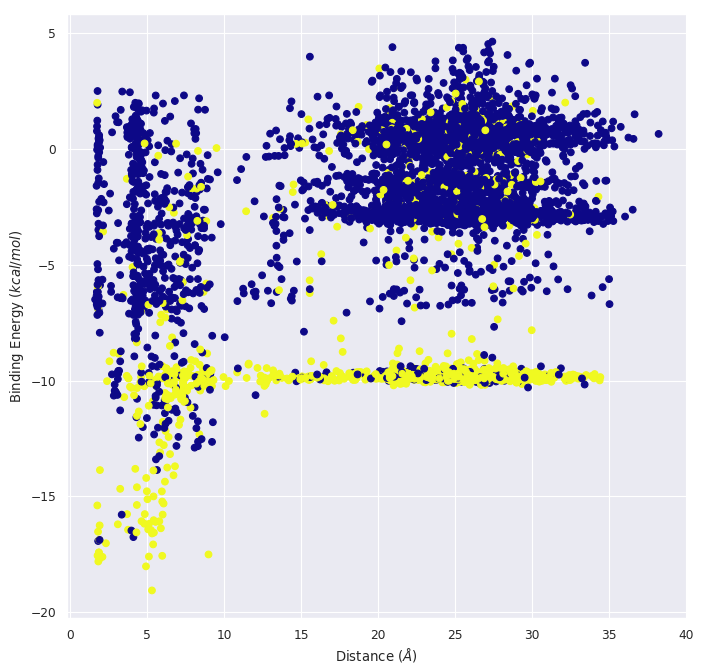

In [23]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, water_energies, c=matchs, cmap=cmap, norm=norm)
plt.show()

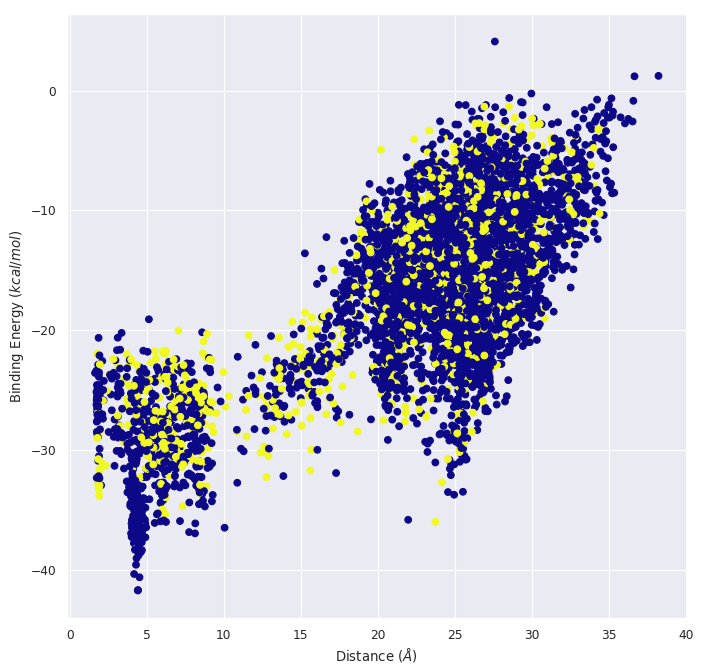

In [24]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, energies, c=matchs, cmap=cmap, norm=norm)
plt.show()

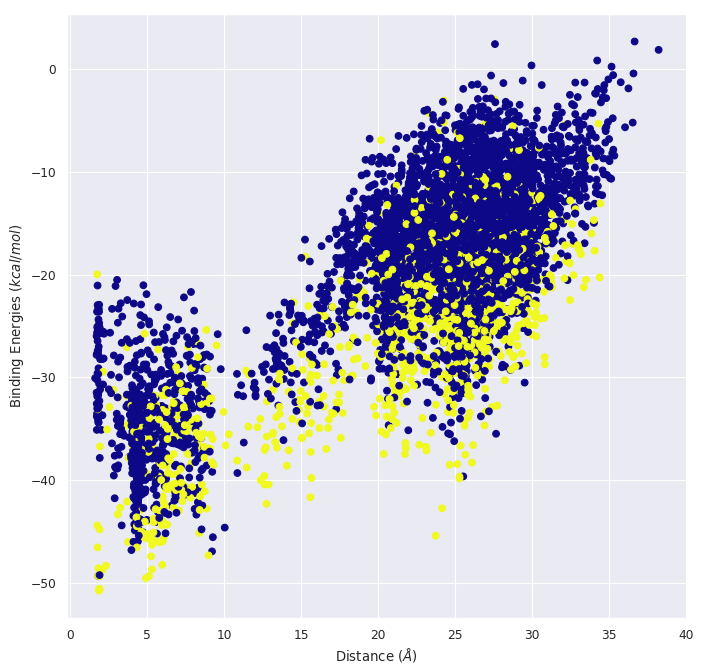

In [25]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energies (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, sum_of_energies, c=matchs, cmap=cmap, norm=norm)
plt.show()

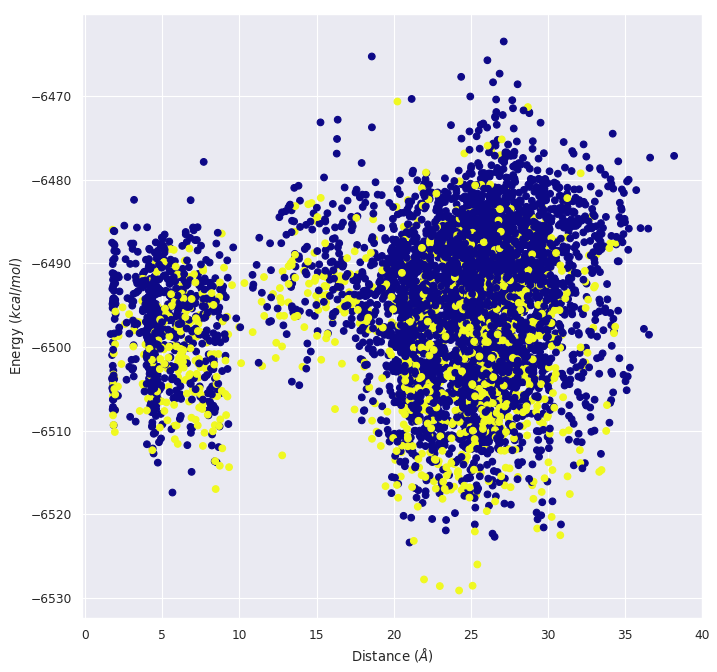

In [26]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, total_energy, c=matchs, cmap=cmap, norm=norm)
plt.show()

In [27]:
#ax = sns.scatterplot(log_densities, list(energy1.values()))
#plt.show()

In [28]:
#ax = sns.scatterplot(log_densities, list(energy2.values()))
#plt.show()

In [29]:
#ax = sns.scatterplot(log_densities, list(energy3.values()))
#plt.show()

# Nonanol (NOL) in MUP at 1000K

## Read Simulation data and extract water info

In [30]:
CONTROL_FILE_PATH = '/home/municoy/LocalResults/waters/1ZNK/1000K/adaptive.conf'
(atom_reports, atom_ids, atom_models, atom_coords), list_of_reports = obtain_water_data_from(CONTROL_FILE_PATH)

- Parsing control file...
  - A total of 40 epochs and 5080 reports were found.
- Listing reports...
- Retrieving data...
- Linking report pointers...
- Parsing data...


## Retrieve reference data

In [31]:
reference = sp.Trajectory('1ZNK_original.pdb', '/home/municoy/LocalResults/waters/1ZNK/1000K/PDB', None, 0, 0, 0)
ref_coords = []
for water_id in WATER_IDS:
    ref_coords.append(reference.getAtoms(water_id)[0].coords)

## Clustering

In [32]:
estimator = cluster.MeanShift(bandwidth=CLUSTERS_WIDTH, n_jobs=NUMBER_OF_PROCESSORS, cluster_all=True)
results = estimator.fit_predict(atom_coords)

In [33]:
reference_clusters = []
for ref_coord in ref_coords:
    reference_clusters += estimator.predict([ref_coord]).tolist()

In [34]:
print(reference_clusters)

[0]


## Clustering analysis

In [35]:
densities = get_density(atom_ids, results)

In [36]:
# matchs_dict is dict will have atom_report + atom_model as key and number of matchs as value
matchs_dict = get_matchs(results, list_of_reports, atom_reports, atom_models)

In [37]:
for report, matchs_per_model in matchs_dict.items():
    report_metrics = [0, ] * FIRST_ATOMS_TO_IGNORE
    for (model, matchs) in sorted(matchs_per_model.items()) :
        report_metrics.append(fulfill_condition(matchs, reference_clusters))

    report.addMetric('waterMatchs', report_metrics)        

## Display results

In [38]:
print('Ref', 'Cluster n.', 'Probability')
for cluster_n, cluster_density in densities.items():
    if (cluster_n in reference_clusters):
        print(' *    ', end='')
    else:
        print('      ', end='')
    print('{:3d}        {:5.3f}'.format(int(cluster_n), float(cluster_density)))

Ref Cluster n. Probability
 *      0        0.446
        1        0.217
        2        0.111
        3        0.043
        4        0.040
        5        0.034
        6        0.034
        7        0.013
        8        0.012
        9        0.014
       10        0.011
       11        0.006
       12        0.008
       13        0.003
       14        0.004
       15        0.001
       16        0.001
       17        0.001
       18        0.000
       19        0.000


In [39]:
write_centroids(estimator, densities, 'NOL_centroids_1000K.pdb', normalize=True)

In [40]:
total_energy = get_metric(list_of_reports, metric_name='currentEnergy')
energies = get_metric(list_of_reports, metric_name='Binding Energy')
water_energies = get_metric(list_of_reports, metric_name='waterBEnergy')
sum_of_energies = [i + j for i, j in zip(energies, water_energies)]
distances = get_metric(list_of_reports, metric_name='Lig-Phe38_distance')
matchs = get_ordered_matchs(list_of_reports, matchs_dict, reference_clusters)
norm = plt.Normalize(0, len(WATER_IDS))
cmap = plt.cm.plasma

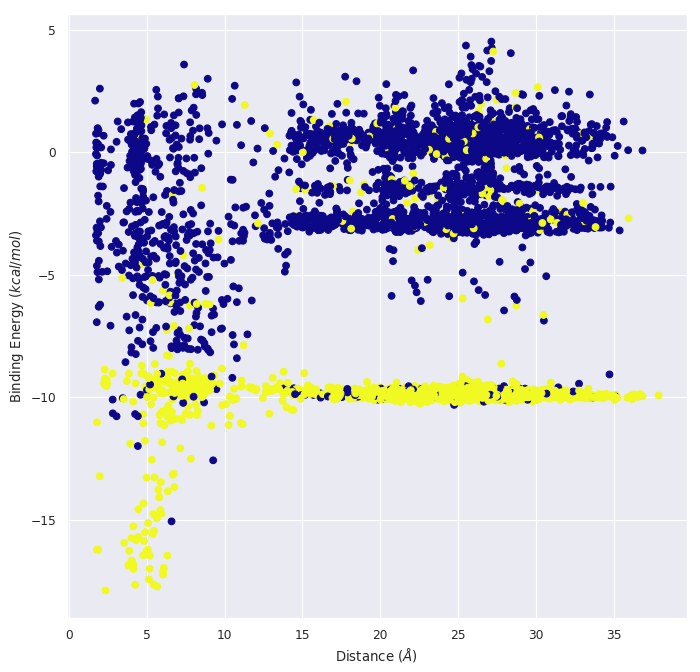

In [41]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, water_energies, c=matchs, cmap=cmap, norm=norm)
plt.show()

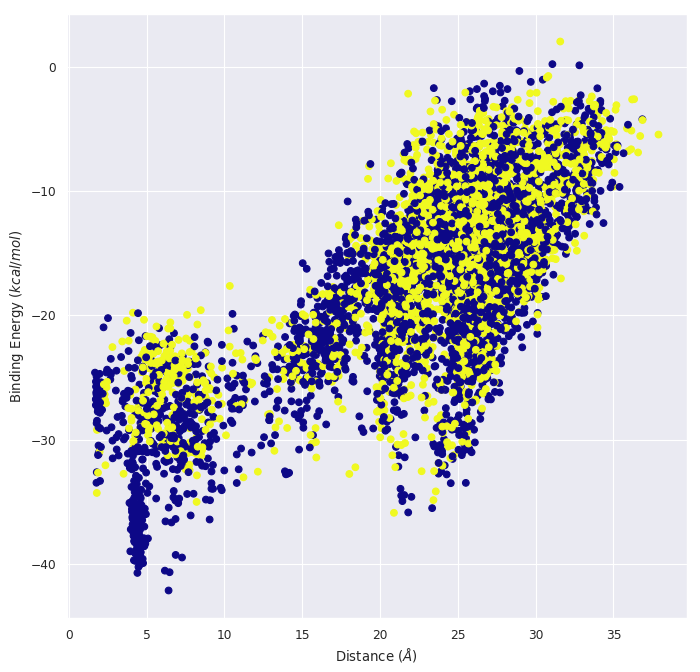

In [42]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, energies, c=matchs, cmap=cmap, norm=norm)
plt.show()

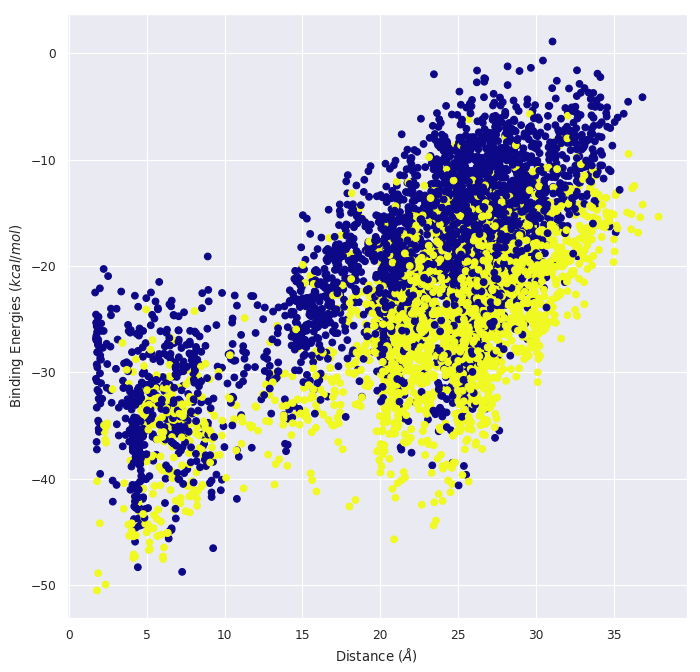

In [43]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energies (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, sum_of_energies, c=matchs, cmap=cmap, norm=norm)
plt.show()

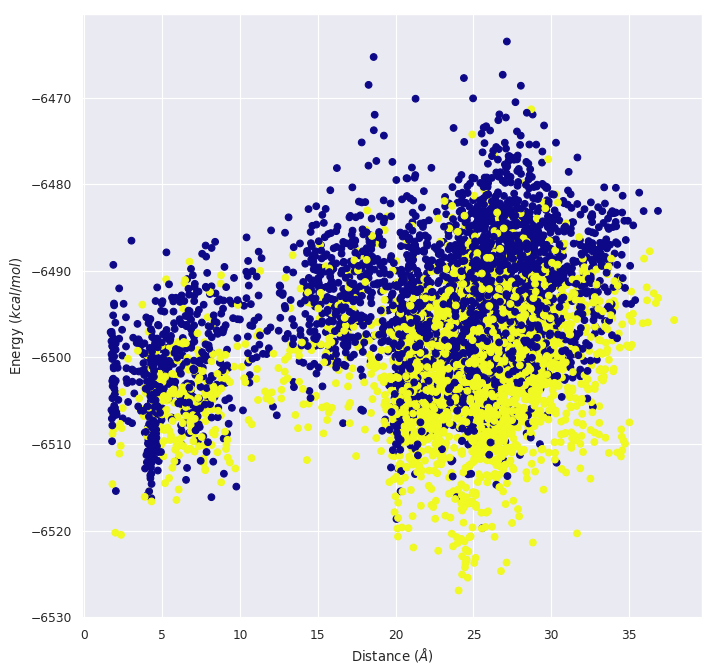

In [44]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, total_energy, c=matchs, cmap=cmap, norm=norm)
plt.show()

# Nonanol (NOL) in MUP at 500K

## Read Simulation data and extract water info

In [45]:
CONTROL_FILE_PATH = '/home/municoy/LocalResults/waters/1ZNK/500K/adaptive.conf'
(atom_reports, atom_ids, atom_models, atom_coords), list_of_reports = obtain_water_data_from(CONTROL_FILE_PATH)

- Parsing control file...
  - A total of 40 epochs and 5080 reports were found.
- Listing reports...
- Retrieving data...
- Linking report pointers...
- Parsing data...


## Retrieve reference data

In [46]:
reference = sp.Trajectory('1ZNK_original.pdb', '/home/municoy/LocalResults/waters/1ZNK/500K/PDB', None, 0, 0, 0)
ref_coords = []
for water_id in WATER_IDS:
    ref_coords.append(reference.getAtoms(water_id)[0].coords)

## Clustering

In [47]:
estimator = cluster.MeanShift(bandwidth=CLUSTERS_WIDTH, n_jobs=NUMBER_OF_PROCESSORS, cluster_all=True)
results = estimator.fit_predict(atom_coords)

In [48]:
reference_clusters = []
for ref_coord in ref_coords:
    reference_clusters += estimator.predict([ref_coord]).tolist()

In [49]:
print(reference_clusters)

[0]


## Clustering analysis

In [50]:
densities = get_density(atom_ids, results)

In [51]:
# matchs_dict is dict will have atom_report + atom_model as key and number of matchs as value
matchs_dict = get_matchs(results, list_of_reports, atom_reports, atom_models)

In [52]:
for report, matchs_per_model in matchs_dict.items():
    report_metrics = [0, ] * FIRST_ATOMS_TO_IGNORE
    for (model, matchs) in sorted(matchs_per_model.items()) :
        report_metrics.append(fulfill_condition(matchs, reference_clusters))

    report.addMetric('waterMatchs', report_metrics)        

## Display results

In [53]:
print('Ref', 'Cluster n.', 'Probability')
for cluster_n, cluster_density in densities.items():
    if (cluster_n in reference_clusters):
        print(' *    ', end='')
    else:
        print('      ', end='')
    print('{:3d}        {:5.3f}'.format(int(cluster_n), float(cluster_density)))

Ref Cluster n. Probability
 *      0        0.476
        1        0.259
        2        0.107
        3        0.035
        4        0.030
        5        0.028
        6        0.027
        7        0.019
        8        0.005
        9        0.004
       10        0.002
       11        0.002
       12        0.002
       13        0.001
       14        0.001
       15        0.001
       16        0.001
       17        0.000
       18        0.000


In [54]:
write_centroids(estimator, densities, 'NOL_centroids_500K.pdb', normalize=True)

In [55]:
total_energy = get_metric(list_of_reports, metric_name='currentEnergy')
energies = get_metric(list_of_reports, metric_name='Binding Energy')
water_energies = get_metric(list_of_reports, metric_name='waterBEnergy')
sum_of_energies = [i + j for i, j in zip(energies, water_energies)]
distances = get_metric(list_of_reports, metric_name='Lig-Phe38_distance')
matchs = get_ordered_matchs(list_of_reports, matchs_dict, reference_clusters)
norm = plt.Normalize(0, len(WATER_IDS))
cmap = plt.cm.plasma

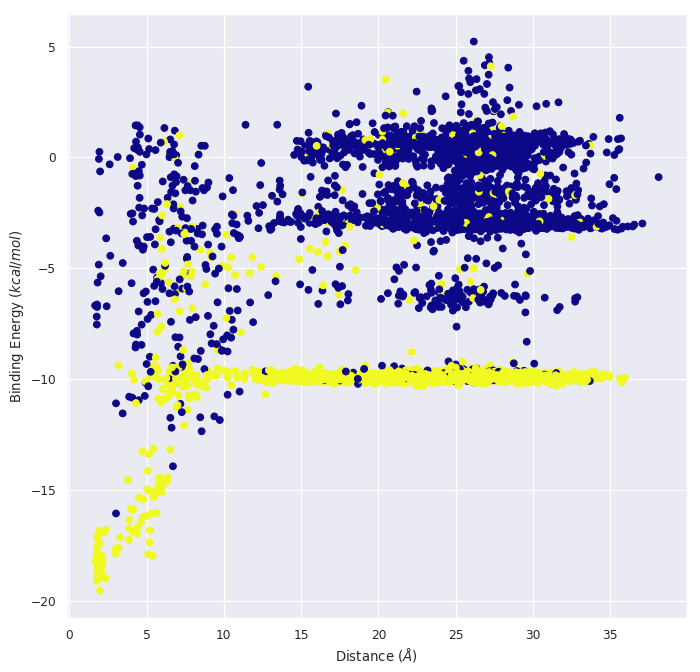

In [56]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, water_energies, c=matchs, cmap=cmap, norm=norm)
plt.show()

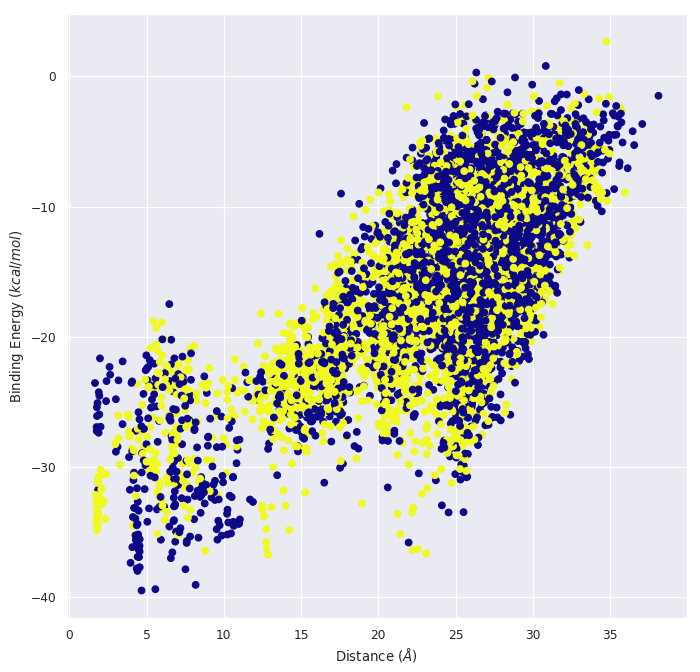

In [57]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, energies, c=matchs, cmap=cmap, norm=norm)
plt.show()

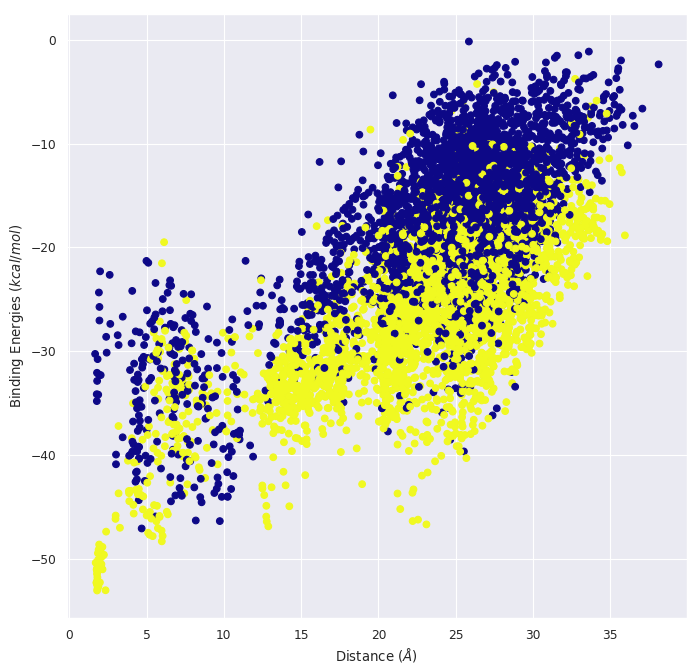

In [58]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energies (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, sum_of_energies, c=matchs, cmap=cmap, norm=norm)
plt.show()

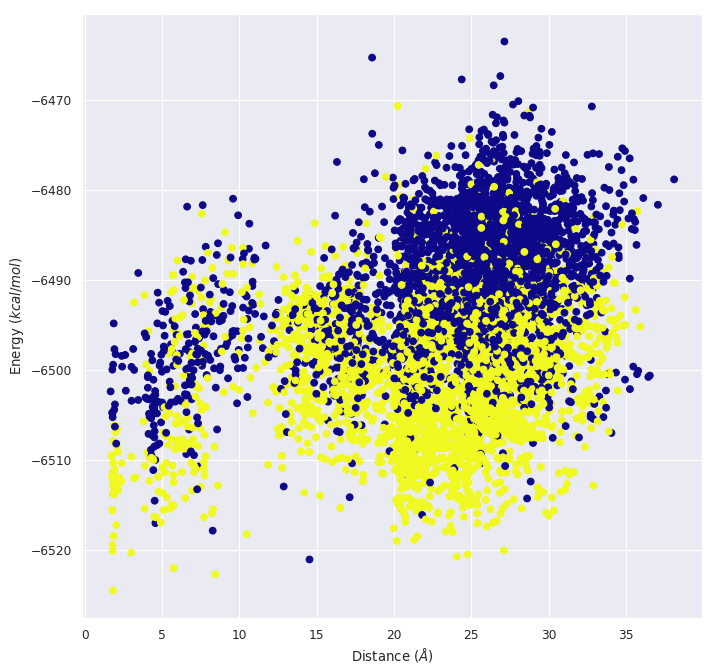

In [59]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, total_energy, c=matchs, cmap=cmap, norm=norm)
plt.show()

# TODO
- Run at a low temperature for WaterMC to see if clusters are enhanced
- Try 2 waters instead of one (one appears to be comfortable lying close to methionine 69, undertaking a hydrogen bond with sulphur atom)